In [3]:
%run helpers.py

In [67]:
import sys

#for future export to external projects
!{sys.executable} -m pip install h5py

In [4]:
#Script to obtain data 
from helpers import * #maybe or maybe not used
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
print(pd.__version__)

1.2.4


We import our large dataset of all happy, chill, and sad playlists

In [6]:
df = pd.read_csv("data/data_moods.csv")

In [7]:
df.reset_index(drop=True)
df.index = np.arange(1, len(df) + 1)

In [8]:
df

,name,album,artist,id,release_date,popularity,danceability,energy,valence,loudness,kmeans
1,You're All I Want,You're All I Want,Cigarettes After Sex,4nvLuqwTOZdEJI1fcHXv8h,2020-05-26,69,0.233,0.4710,0.277,-10.947,chill
2,Tides,Tides,Bonobo,7rRYiBxeudiHMNmgptnne9,2021-10-20,66,0.600,0.3140,0.201,-9.109,chill
3,I’ll Keep You Safe,I’ll Keep You Safe,Vluestar,3YfNhioGntblm6ciPsCwC9,2018-05-08,73,0.540,0.3410,0.283,-10.399,chill
4,Water Theme,Winter Flower,Clams Casino,3teH1kAL5KrlUYosdt2nJI,2021-11-17,56,0.295,0.3570,0.352,-9.116,chill
5,I Need U,I Need U,yaeow,5lbdxt9C6rsELTimTkyMn8,2020-05-28,chill,0.402,0.4050,0.072,-12.486,chill
...,...,...,...,...,...,...,...,...,...,...,...
691,Hurt for Me,Hurt for Me,SYML,34ngvjIBKbCL9ECqIhbxaZ,2016-09-09,53,0.548,0.0460,0.176,-17.929,sad
692,I Can't Carry This Anymore,I Can't Carry This Anymore,Anson Seabra,1NNnmmBEaId0uoWfvtNd8F,2019-01-11,1,0.451,0.0873,0.456,-16.815,sad
693,Sinking Ship,Expectations,Wild Child,7orUPsozJ19Cyxv5ozoREr,2018-02-09,38,0.555,0.1810,0.182,-19.296,sad
694,Shadow,Shadow,Jimmy Levy,5heMraZsTO2tPCsdeoKCXE,2018-12-07,50,0.509,0.1580,0.327,-16.141,sad


We pull out the neccessary column features that can affect our audio signatures in classifying the mood of the songs. 
We then use MinMaxScaler to scale our data values between 0s and 1s.

In [9]:
col_features = df.columns[6:-1]

In [10]:
col_features

Index(['danceability', 'energy', 'valence', 'loudness'], dtype='object')

In [11]:
# col_features = df.columns[['danceability', 'valence', 'loudness']]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['kmeans']

In [12]:
X2

array([[  0.233,   0.471,   0.277, -10.947],
       [  0.6  ,   0.314,   0.201,  -9.109],
       [  0.54 ,   0.341,   0.283, -10.399],
       ...,
       [  0.555,   0.181,   0.182, -19.296],
       [  0.509,   0.158,   0.327, -16.141],
       [  0.567,   0.128,   0.3  , -17.313]])

We then encode the categories that we want to predict, which are happy, chill, sad.

In [13]:
#Encode the categories
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)

In [14]:
encoded_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.35,random_state=30)
print(len(X_train))
print(len(Y_train))
target = pd.DataFrame({'kmeans':df['kmeans'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

451
451


,kmeans,encode
0,chill,0
353,happy,1
617,sad,2


We run the RandomForestClassifer to create a confusion matrix for predicting genres

In [16]:
model = RandomForestClassifier(n_estimators=300).fit(X_train,Y_train)
predictionforest = model.predict(X_test)
print(confusion_matrix(Y_test,predictionforest))
print(classification_report(Y_test,predictionforest))

[[122   5   1]
 [  6  86   0]
 [  0   0  24]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       128
           1       0.95      0.93      0.94        92
           2       0.96      1.00      0.98        24

    accuracy                           0.95       244
   macro avg       0.95      0.96      0.96       244
weighted avg       0.95      0.95      0.95       244



We can see that this model gives us an average of 93-95% accuracy in predicting the song's mood.

In [17]:
def base_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(8,input_dim=4,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(3,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [18]:
test_model = base_model()

In [19]:
#Configure the model
estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)

In [20]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Baseline: 89.78% (5.22%)


In [21]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [22]:
print(len(Y_test))
print(len(y_preds))
print(y_preds)
print(Y_test)

244
244
[1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1
 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1
 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0
 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0]
[1 1 0 1 2 0 0 1 1 2 0 0 0 2 1 2 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0
 0 0 0 0 0 2 0 0 0 1 1 1 0 0 0 0 2 0 1 1 1 1 1 1 1 1 0 1 0 0 2 1 1 0 1 2 1
 1 1 0 1 0 1 0 0 0 0 2 2 1 2 1 1 2 0 0 1 1 0 0 0 0 0 0 0 1 2 0 1 0 0 2 1 1
 0 1 1 2 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 2 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 1 1 1 1 0 0 1 1 1 1 1 2 0 2 1 0 0 0 0 0 0 1 0 0 2 0 1 0 0 1 0 0 0 0
 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 2 0 1 0 0 0 0 0 1 0 2 2 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 2 0 2 0 1 0]


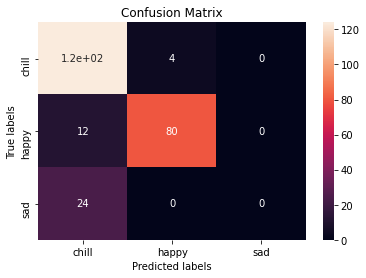

Accuracy Score 0.8360655737704918


In [23]:
cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['kmeans']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

The confusion matrix from Sequential method from Tensorflow gives us an accuracy of 83%

Function to predict song

In [50]:
#Don't really understand this
def predict_mood(id_song):
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
                                                                                 batch_size=200,verbose=0))])
        #Fit the Pipeline
    pip.fit(X2,encoded_y)
    
        #Obtain the features of the song

    preds = get_songs_features(id_song)
#     print("preds " + str(preds))

    get_required = get_song_signatures(id_song)[0]
    get_required

        #Pre-process the features to input the Model
    preds_features = np.array(get_required[7:]).reshape(1,-1)
    print("features " + str(preds_features))

        #Predict the features of the song
    results = pip.predict(preds_features)

    print("results " + str(results))
    mood = np.array(target['kmeans'][target['encode']==int(results)])
    name_song = preds[0][0]
    artist = preds[0][2]

    return print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))
#     print(f"{name_song} by {artist} is a {mood[0].upper()} song")
    
    



In [51]:
def predict_mood_clf(id_song):
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('clf',RandomForestClassifier(max_depth=3, random_state = 0))])
        #Fit the Pipeline
    pip.fit(X2,encoded_y)
    
        #Obtain the features of the song

    preds = get_songs_features(id_song)
#     print("preds " + str(preds))

    get_required = get_song_signatures(id_song)[0]
    get_required

        #Pre-process the features to input the Model
    preds_features = np.array(get_required[7:]).reshape(1,-1)
    print("features " + str(preds_features))

        #Predict the features of the song
    results = pip.predict(preds_features)
    print("results " + str(results))
    mood = np.array(target['kmeans'][target['encode']==int(results)])
    name_song = preds[0][0]
    artist = preds[0][2]

    return print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))
#     print(f"{name_song} by {artist} is a {mood[0].upper()} song")

Some sample songs you can try out

In [52]:
chill = '2YwDDVHflNhUKgu70WR7OH' #Queen of Paisley by Silas Short
sad = '2Djv53hoQWobBuNHkSKpXC' #Some kind of jazzy sad piano melody
happy = '3xKsf9qdS1CyvXSMEid6g8' #Pink+White by Frank Ocean

In [53]:
print(predict_mood('6Jl3ZOX6MUOlyoUc721bsX'))
print(predict_mood_clf('2Djv53hoQWobBuNHkSKpXC'))

features [[  0.567   0.263   0.247 -13.51 ]]
results [0]
A Song About Being Sad by Rex Orange County is a CHILL song
None
features [[ 3.3200e-01  1.9100e-02  2.2200e-01 -2.9569e+01]]
results [2]
Bellevue by Franz Becker is a SAD song
None


### spotify:track:0u2P5u6lvoDfwTYjAADbn4 ###
spotify:track:0JP9xo3adEtGSdUEISiszL
spotify:track:60nZcImufyMA1MKQY3dcCH
spotify:track:0LuVpXVTaWY9Un2w9GkXjf

In [79]:
print(predict_mood('0LuVpXVTaWY9Un2w9GkXjf'))



features [[  0.346   0.133   0.332 -11.954]]
results [0]
Mad World by Michael Andrews is a CHILL song
None


In [30]:
print(predict_mood('3dPQuX8Gs42Y7b454ybpMR')) #Seven Nation's Army

features [[ 0.743  0.446  0.278 -7.807]]
results [0]
Seven Nation Army by The White Stripes is a CHILL song
None


In [146]:
print(predict_mood('2zzLRQ78kKfPTx8FJQCdC2')) #Arctic Monkeys

preds (['When The Sun Goes Down', "Whatever People Say I Am, That's What I'm Not", 'Arctic Monkeys', '2zzLRQ78kKfPTx8FJQCdC2', '2006-01-29', 75, 202133, 0.348, 0.0341, 0.875, 0, 0.117, 0.407, -4.758, 0.199, 169.152, 11, 4], ['name', 'album', 'artist', 'id', 'release_date', 'popularity', 'length', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'valence', 'loudness', 'speechiness', 'tempo', 'key', 'time_signature'])
features [[ 0.348  0.875  0.407 -4.758]]
results [1]
When The Sun Goes Down by Arctic Monkeys is a HAPPY song
None


In [58]:
import random

In [72]:
def print_result_playlist(df):
    i = random.randrange(len(df)-1)
    print(f"{predict_mood(df['id'].values[i])} is sequential prediction")
    print("--------------------------------------------------------------")
    print(f"{predict_mood_clf(df['id'].values[i])} is randomforest prediction")
    print("END________________________________________________________END")
    print()

In [47]:
df['id'].values[1]

'7rRYiBxeudiHMNmgptnne9'

In [73]:
#run this loop and change the range so we can compare if the songs emotions are similar or not!
for i in range(20):
    print_result_playlist(df)

features [[ 0.711  0.412  0.186 -6.827]]
results [0]
Cold by Boy In Space is a CHILL song
None is sequential prediction
--------------------------------------------------------------
features [[ 0.711  0.412  0.186 -6.827]]
results [0]
Cold by Boy In Space is a CHILL song
None is randomforest prediction
END________________________________________________________END

features [[ 4.4800e-01  5.0400e-03  3.3000e-01 -2.7869e+01]]
results [2]
Lilou by Oscar Melone is a SAD song
None is sequential prediction
--------------------------------------------------------------
features [[ 4.4800e-01  5.0400e-03  3.3000e-01 -2.7869e+01]]
results [2]
Lilou by Oscar Melone is a SAD song
None is randomforest prediction
END________________________________________________________END

features [[ 0.727  0.729  0.512 -2.99 ]]
results [1]
American Boy by Estelle is a HAPPY song
None is sequential prediction
--------------------------------------------------------------
features [[ 0.727  0.729  0.512 -2.99 